## Install and import useful libraries

In [4]:
%pip install pandas pyfluids sympy scipy numpy matplotlib

import pandas as pd # This makes nice tables
import pyfluids # This does the thermodynamics
import math
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Valve Specific Constants

In [6]:
min_C_V = 0.025
max_C_V = 0.500

## Implement the Tables from the Google Doc as Pandas DataFrames

In [7]:
operating_conditions = pd.DataFrame([
  {'Ambient condition (°C)': -20, 'T1 (°C)': -20, 'T2 (°C)': -14, 'T3 (°C)': 46, 'T4 (°C)': 250, 'T5 (°C)': 129, 'T6 (°C)': 6.6, 'P1 (Pa)': 3.3e6, 'P2 (Pa)': 15e6, 'm-dot (kg/s)': 4.9},
  {'Ambient condition (°C)': -10, 'T1 (°C)': -10, 'T2 (°C)': -2, 'T3 (°C)': 50, 'T4 (°C)': 250, 'T5 (°C)': 129, 'T6 (°C)': 15.4, 'P1 (Pa)': 3.3e6, 'P2 (Pa)': 15e6, 'm-dot (kg/s)': 4.9},
  {'Ambient condition (°C)': 0, 'T1 (°C)': 0, 'T2 (°C)': 10, 'T3 (°C)': 58, 'T4 (°C)': 250, 'T5 (°C)': 135, 'T6 (°C)': 28.8, 'P1 (Pa)': 3.9e6, 'P2 (Pa)': 16e6, 'm-dot (kg/s)': 5.2},
  {'Ambient condition (°C)': 10, 'T1 (°C)': 10, 'T2 (°C)': 23, 'T3 (°C)': 68, 'T4 (°C)': 250, 'T5 (°C)': 143, 'T6 (°C)': 46.0, 'P1 (Pa)': 5e6, 'P2 (Pa)': 18e6, 'm-dot (kg/s)': 5.8},
  {'Ambient condition (°C)': 20, 'T1 (°C)': 20, 'T2 (°C)': 38, 'T3 (°C)': 80, 'T4 (°C)': 250, 'T5 (°C)': 150, 'T6 (°C)': 63.9, 'P1 (Pa)': 6.2e6, 'P2 (Pa)': 20e6, 'm-dot (kg/s)': 6.4},
  {'Ambient condition (°C)': 30, 'T1 (°C)': 30, 'T2 (°C)': 57, 'T3 (°C)': 96, 'T4 (°C)': 250, 'T5 (°C)': 160, 'T6 (°C)': 82.1, 'P1 (Pa)': 7.4e6, 'P2 (Pa)': 20.7e6, 'm-dot (kg/s)': 6.5},
  {'Ambient condition (°C)': 40, 'T1 (°C)': 40, 'T2 (°C)': 71, 'T3 (°C)': 117, 'T4 (°C)': 250, 'T5 (°C)': 181, 'T6 (°C)': 94.6, 'P1 (Pa)': 9.2e6, 'P2 (Pa)': 19.9e6, 'm-dot (kg/s)': 5.5},
  {'Ambient condition (°C)': 50, 'T1 (°C)': 50, 'T2 (°C)': 85, 'T3 (°C)': 145, 'T4 (°C)': 250, 'T5 (°C)': 198, 'T6 (°C)': 102.8, 'P1 (Pa)': 10e6, 'P2 (Pa)': 17.8e6, 'm-dot (kg/s)': 4}
])

operating_conditions

,Ambient condition (°C),T1 (°C),T2 (°C),T3 (°C),T4 (°C),T5 (°C),T6 (°C),P1 (Pa),P2 (Pa),m-dot (kg/s)
0,-20,-20,-14,46,250,129,6.6,3300000.0,15000000.0,4.9
1,-10,-10,-2,50,250,129,15.4,3300000.0,15000000.0,4.9
2,0,0,10,58,250,135,28.8,3900000.0,16000000.0,5.2
3,10,10,23,68,250,143,46.0,5000000.0,18000000.0,5.8
4,20,20,38,80,250,150,63.9,6200000.0,20000000.0,6.4
5,30,30,57,96,250,160,82.1,7400000.0,20700000.0,6.5
6,40,40,71,117,250,181,94.6,9200000.0,19900000.0,5.5
7,50,50,85,145,250,198,102.8,10000000.0,17800000.0,4.0


* P2 = P3 = P4 
* P1 = P5 = P6

In [8]:
startup_conditions = pd.DataFrame({'Ambient condition (°C)': [20], 'T1 (°C)': [20], 'T2 (°C)': [27], 'T3 (°C)': [207], 'T4 (°C)': [250], 'T5 (°C)': [238], 'T6 (°C)': [73], 'P1 (Pa)': [6.2e6], 'P2 (Pa)': [11e6], 'm-dot (kg/s)': [3]})

startup_conditions

,Ambient condition (°C),T1 (°C),T2 (°C),T3 (°C),T4 (°C),T5 (°C),T6 (°C),P1 (Pa),P2 (Pa),m-dot (kg/s)
0,20,20,27,207,250,238,73,6200000.0,11000000.0,3


In [9]:
data = {'T (°C)': [150],
    'delta P (Pa)': [2.1e6],
    'Mass flow (kg/s)': [0.26]}

bearing_requirements = pd.DataFrame(data)

bearing_requirements


,T (°C),delta P (Pa),Mass flow (kg/s)
0,150,2100000.0,0.26


## Modeling

### CO_2 as a working fluid

In [10]:
from pyfluids import Fluid, FluidsList, Input

c_ohh_two = Fluid(FluidsList.CarbonDioxide)


cold_two = c_ohh_two.with_state(
    Input.pressure(100e3), Input.temperature(-20)
)
print(cold_two.enthalpy, cold_two.entropy, cold_two.density)

468540.59103611164 2603.75424704758 2.108951810313363


### Valve Model from First Principles

In [11]:
def valve_calc(h_one, P_one, m_dot, P_three, increment = 0.1e6, DEBUG=False):
  """
  Calculates the valve coefficient, outlet temperature, and outlet density for a given valve system.

  Parameters:
  - h_one (float): Enthalpy at the inlet (state one)
  - P_one (float): Pressure at the inlet (state one)
  - m_dot (float): Mass flow rate
  - P_three (float): Pressure at the outlet (state three)
  - increment (float, optional): Pressure decrement increment for iteration (default: 0.1e6)
  - DEBUG (bool, optional): Flag to enable debug mode (default: False)

  Returns:
  - C_V (float): Valve coefficient
  - t_three (float): Outlet temperature (state three)
  - rho_three (float): Outlet density (state three)
  """
  assert P_one > P_three, "P_one must be greater than P_three or else no flow will occur"

  # compute input enthalpy, entropy, & density with fluids
  state_one = c_ohh_two.with_state(
    Input.pressure(P_one), Input.enthalpy(h_one)
  )
  h_one = state_one.enthalpy
  s_one = state_one.entropy
  rho_one = state_one.density

  # Assume the velocity is zero at the inlet
  V_one = 0
  
  # Isentropic expansion to the throttle point
  s_two = s_one

  # Init our outputs before we loop (these values do not matter)
  V_two = 1
  c_two = 100.0

  P_two = P_one

  C_V = math.inf

  # Check that the min enthalpy at state two is less than state one
  # If it is not, we have a problem
  state_two_min = c_ohh_two.with_state(
    Input.pressure(P_three), Input.entropy(s_two)
  )
  h_two_min = state_two_min.enthalpy
  assert h_two_min < h_one


  # Guess a pressure for the choke and iterate until the velocity is mach one or we drop below the pressure floor
  
  # print("V_two {}, c_two {}, P_two {} P_three {}".format(V_two, c_two, P_two, P_three))
  while not c_two or V_two < c_two and P_two > P_three:
    # h_two, rho_two, c_two = lookup(s_two, P_two)
    state_two = c_ohh_two.with_state(
      Input.pressure(P_two), Input.entropy(s_two)
    )
    h_two = state_two.enthalpy
    rho_two = state_two.density
    c_two = state_two.sound_speed


    discriminant = 2 * (h_one - h_two) + V_one**2
    if (discriminant > 0):
      V_two = discriminant ** 0.5
      A_two = m_dot / (V_two * rho_two)
      C_d = P_three / P_two
      C_V = 58888.5 * C_d * A_two

    P_two -= increment

  # print("C_d", C_d)

  if DEBUG:
    if not c_two:
      print("Failed to converge")
      print("V_two {}, c_two {}, P_two {} P_three {}".format(V_two, c_two, P_two, P_three))

    if V_two > c_two:
      print("Velocity fail: V_two {}, c_two {}".format(V_two, c_two))
    else:
      print("Pressure fail: P_two {}, P_three {}".format(P_two, P_three))
      print("h_one: {}, h_two: {}".format(h_one, h_two))
  

  h_three = h_one

  state_three = c_ohh_two.with_state(
    Input.pressure(P_three), Input.enthalpy(h_three)
  )

  t_three = state_three.temperature
  rho_three = state_three.density

  return C_V, t_three, rho_three

### Valve Drop Given C_V

In [12]:
def valve_drop(h_one, P_exit, m_dot, target_C_V, increment = 0.025e6, DEBUG=False):
  assert target_C_V > 0, "C_V must be greater than zero"

  p_drop = math.inf
  P_one = P_exit
  while P_one - P_exit < p_drop:

    # compute input enthalpy, entropy, & density with fluids
    state_one = c_ohh_two.with_state(
      Input.pressure(P_one), Input.enthalpy(h_one)
    )
    h_one = state_one.enthalpy
    s_one = state_one.entropy
    rho_one = state_one.density

    # Assume the velocity is zero at the inlet
    V_one = 0
    
    # Isentropic expansion to the throttle point
    s_two = s_one

    # Init our outputs before we loop (these values do not matter)
    V_two = 1
    c_two = 100.0

    P_two = P_one

    C_V = math.inf
    
    C_d = 0.81


    # Guess a pressure for the throttle and iterate until the C_V agrees with the input
    
    while not c_two or V_two < c_two and C_V > target_C_V:
      # h_two, rho_two, c_two = lookup(s_two, P_two)
      state_two = c_ohh_two.with_state(
        Input.pressure(P_two), Input.entropy(s_two)
      )
      h_two = state_two.enthalpy
      rho_two = state_two.density
      c_two = state_two.sound_speed


      discriminant = 2 * (h_one - h_two) + V_one**2
      if (discriminant > 0):
        V_two = discriminant ** 0.5
        A_two = m_dot / (V_two * rho_two)
        C_V = 58888.5 * C_d * A_two

      P_two -= increment

    if DEBUG:
      if not c_two:
        print("Failed to converge")
        print("V_two {}, c_two {}, P_two {} P_three {}".format(V_two, c_two, P_two, P_three))

      if V_two > c_two:
        print("Velocity fail: V_two {}, c_two {}".format(V_two, c_two))
      else:
        print("C_V exit: P_two {}, P_three {}".format(P_two, P_three))
        print("h_one: {}, h_two: {}".format(h_one, h_two))
    

    P_three = P_two * C_d
    p_drop = P_one - P_three

    P_one += increment

  return p_drop

### Filter Pressure Drop Modeling

In [13]:
#Returns the pressure drop across the filter in Pa
#Takes temperature and pressure to define input state
def filter_modeling(t_input, P_input, m_dot):
  """
  Calculates the pressure drop across a filter system.

  Args:
    t_input (float): Temperature input in Celcius.
    P_input (float): Pressure input in Pascal.
    m_dot (float): Mass flow rate in kg/s.

  Returns:
    float: Pressure drop across the filter system in Pascal.
  """
  #Compute input enthalpy, entropy, & density with fluids
  #   Create the specified state point using temp and pressure inputs
  state_input = c_ohh_two.with_state(
  Input.pressure(P_input), Input.temperature(t_input))
  #Get h, s, rho, and kinematic viscosity for input state
  h_input = state_input.enthalpy
  s_input = state_input.entropy
  rho_input = state_input.density
  viscosity_input = state_input.kinematic_viscosity

  #Calculate volumetric flow rate in m^3 / s
  V_dot = m_dot / rho_input
  
  #Convert V_dot to GPM
  V_dot_GPM = V_dot * 264.1721769 * 60
  
  #Check that the flowrate does not exceed filter specs
  assert V_dot_GPM < 24 
  
  #Calculate Specific Gravity
  s_gravity = rho_input / 1000

  #Convert to Centistoke (m^2/s)
  viscosity_centi = viscosity_input * 1E6

  #Convert to SSU
  SSU_guess = 29

  def ssuConversion(SSU, viscosity):
    return 0.226*SSU - (195/SSU) - viscosity

  # Solve the equation numerically
  SSU_converted = scipy.optimize.fsolve(ssuConversion, SSU_guess, args=(viscosity_centi,))
  SSU_one = SSU_converted[0]

  #PSID Drop for Housing
  #   for 1" Pipe (Using quadratic curve fit)
  pDrop_housing = 0.0672 * V_dot_GPM + 8.21E-4 * V_dot_GPM * V_dot_GPM
  
  #PSID Drop for Filter Element
  pDrop_filter  = 0.0618 * V_dot_GPM + .0108 * V_dot_GPM * V_dot_GPM
  

  #Add pressure drops for housing and filter elements
  #   Convert pressure drop to new fluid using SSU
  pDrop = (pDrop_housing + pDrop_filter) * (SSU_one/100) * s_gravity / 0.9

  #Convert psi to Pa
  pDrop = pDrop * 6894.76

  return pDrop

print(filter_modeling(250, 20E6, 0.25))

3056.6593294126096


### Calculate the Effective Area of the Filter Based on Pressure Drop

In [14]:
def filter_area(t_input, P_input, m_dot, P_drop):
    """
  Calculates the pressure drop across a filter system.

  Args:
    t_input (float): Temperature input in Celcius.
    P_input (float): Pressure input in Pascal.
    m_dot (float): Mass flow rate in kg/s.
    P_drop (float): Pressure drop over filter

  Returns:
    float: The effective area of the filter
  """


    #Define Input State
    #   Create the specified state point using temp and pressure inputs
    state_input = c_ohh_two.with_state(
    Input.pressure(P_input), Input.temperature(t_input))

    #Get h, s, rho, and kinematic viscosity for input state
    h_input = state_input.enthalpy
    s_input = state_input.entropy

    #Output state 
    h_output = h_input
    P_output = P_input - P_drop

    #Define Throttle State
    s_throttle = s_input
    P_throttle = P_output
    
    state_throttle = c_ohh_two.with_state(
    Input.pressure(P_throttle), Input.entropy(s_throttle))
    
    #Get properties at throttle
    h_throttle = state_throttle.enthalpy
    rho_throttle = state_throttle.density

    #Model the filter as valve to find velocity and area at the throttle
    v_throttle = (2 * (h_input - h_throttle)) ** (1/2)
    effective_Area = m_dot / (v_throttle * rho_throttle)


    return effective_Area
print(filter_area(250, 20E6, 0.25, filter_modeling(250, 20E6, 0.25)))
print(filter_area(250, 20E6, 0.25, 9.5809e+06))

0.00021610690072184887
5.5957324718612625e-06


# Solve the Bearing Supply problem given sources and sink

In [15]:
sources = [1, 2]
sink = 3

cond_row = operating_conditions.iloc[0]
cond_row

# Required mass flow rate
m_dot_ent = bearing_requirements['Mass flow (kg/s)'][0]

TOLERANCE = 1e-5

def test_setup(sources, sink, cond_row):
  """
  Perform a test setup for a system with multiple sources and a sink.

  Args:
    sources (list): Pair of sources to draw from.
    sink (int): Identifier of the sink.
    cond_row (dict): Dictionary containing the conditions for all nodes in the cycle.

  Returns:
    tuple: A tuple containing the valve coefficients for the left and right sources, the excess pressure, and the percentage that the filter can be.
  """
  cond_values = {}

  for s in list(sources) + [sink]:
    if s in (2, 3, 4):
      cond_values[s] = {
        'T': cond_row['T{} (°C)'.format(s)],
        'P': cond_row['P2 (Pa)']
      }
    else:
      cond_values[s] = {
        'T': cond_row['T{} (°C)'.format(s)],
        'P': cond_row['P1 (Pa)']
      }

  # Bearing entrance pressure is P_sink + delta_P
  P_ent = cond_values[sink]['P'] + bearing_requirements['delta P (Pa)'][0]
  
  # Check that there is enough pressure from source to tee to drive the flow
  if P_ent > cond_values[sources[0]]['P'] or P_ent > cond_values[sources[1]]['P']:
    return False, "Pressure", (math.inf, math.inf, 0, 0)

  # Entrance enthalpy can be computed with coolprop
  entrance = c_ohh_two.with_state(
      Input.pressure(P_ent), Input.temperature(bearing_requirements['T (°C)'][0])
  )
  h_ent = cold_two.enthalpy

  # Determine the source, post-valve enthalpies with coolprop. Assuming adiabatic conditions in valve
  for s in sources:
    source_state = c_ohh_two.with_state(
      Input.pressure(cond_values[s]['P']), Input.temperature(cond_values[s]['T'])
    )
    h_post = source_state.enthalpy

    cond_values[s]['h_post'] = h_post

  # Determine the required mass flow rate mixture given the enthalpies
  # m_dot_ent = m_dot_left + m_dot_right
  # m_dot_ent * h_ent = m_dot_left * h_left + m_dot_right * h_right

  left = sources[0]
  right = sources[1]

  # The filter is assumed to be adiabatic so the enthalpy of the sources remains the same as the draw point
  h_left = cond_values[left]['h_post']
  h_right = cond_values[right]['h_post']

  # Check that target enthalpy is between the source enthalpies
  if (h_ent < h_left and h_ent < h_right) or (h_ent > h_left and h_ent > h_right):
    return False, "Enthalpy", (math.inf, math.inf, 0, 0)

  m_dot_left = m_dot_ent * (h_ent - h_right) / (h_left - h_right)
  m_dot_right = m_dot_ent - m_dot_left

  assert abs(m_dot_ent - (m_dot_left + m_dot_right)) < TOLERANCE, "Mass flow rates do not sum to the required value {} != {}".format(m_dot_ent, m_dot_left + m_dot_right)
  assert abs(m_dot_ent * h_ent - (m_dot_left * h_left + m_dot_right * h_right)) < TOLERANCE, "Enthalpies do not sum to the required value {} != {}".format(m_dot_ent * h_ent, m_dot_left * h_left + m_dot_right * h_right)

  # Check that the mass flow rates are positive
  assert m_dot_left > 0 and m_dot_right > 0, "Mass flow rates must be positive"

  cond_values[left]['m_dot'] = m_dot_left
  cond_values[right]['m_dot'] = m_dot_right

  # Check the pre-tee filter pressure drops
  p_drop_left = filter_modeling(cond_values[left]['T'], cond_values[left]['P'], m_dot_left)
  p_drop_right = filter_modeling(cond_values[right]['T'], cond_values[right]['P'], m_dot_right)

  p_post_left = cond_values[left]['P'] - p_drop_left
  p_post_right = cond_values[right]['P'] - p_drop_right

  # Check that the post filter pressures are greater than tee pressure
  if p_post_left < P_ent or p_post_right < P_ent:
    return False, "Filter Pressure", (math.inf, math.inf, 0, 0)
  
  # Use Max C_V to calculate the minimum valve drop
  try:
    left_min_valve_drop = valve_drop(h_left, P_ent, m_dot_left, max_C_V)
    right_min_valve_drop = valve_drop(h_right, P_ent, m_dot_right, max_C_V)
  except ValueError:
    return False, "Valve Drop", (math.inf, math.inf, 0, 0)

  #Calculate excess pressure on left filter and solve for area ratio
  P_excess_left = cond_values[left]['P'] - P_ent - left_min_valve_drop
  A_unclogged_left = filter_area(cond_values[left]['T'], cond_values[left]['P'], m_dot_left,p_drop_left)
  A_clogged_left = filter_area(cond_values[left]['T'], cond_values[left]['P'], m_dot_left,P_excess_left)
  A_ratio_left = (1 - A_clogged_left / A_unclogged_left) * 100

  #Calculate excess pressure on right filter and solve for area ratio
  P_excess_right = cond_values[right]['P'] - P_ent - right_min_valve_drop
  A_unclogged_right = filter_area(cond_values[right]['T'], cond_values[right]['P'], m_dot_right,p_drop_right)
  A_clogged_right = filter_area(cond_values[right]['T'], cond_values[right]['P'], m_dot_right,P_excess_right)
  A_ratio_right = (1 - A_clogged_right / A_unclogged_right) * 100

  #Take minimum area ratio and excess pressure
  A_ratio = min(A_ratio_left, A_ratio_right)
  P_excess = min(P_excess_left - p_drop_left, P_excess_right - p_drop_right)
  
  C_V_left = math.inf
  C_V_right = math.inf

  # Compute the valve coefficients
  try:
    C_V_left, t_three_left, rho_three_left = valve_calc(h_left, p_post_left, m_dot_left, P_ent)
    C_V_right, t_three_right, rho_three_right = valve_calc(h_right, p_post_right, m_dot_right, P_ent)
  except ValueError:
    return False, "Valve Prop", (C_V_left, C_V_right, P_excess, A_ratio, m_dot_left)
    
  return True, "", (C_V_left, C_V_right, P_excess, A_ratio, m_dot_left)

test_setup((2, 4), 1, cond_row)

(True,
 '',
 (0.04379343425402294,
  0.1812078818463976,
  6780062.247066519,
  97.75244622746467,
  0.10606050122500152))

left: 2, right: 4, sink: (1, 5, 6) is valid
hits: 1, tries: 30


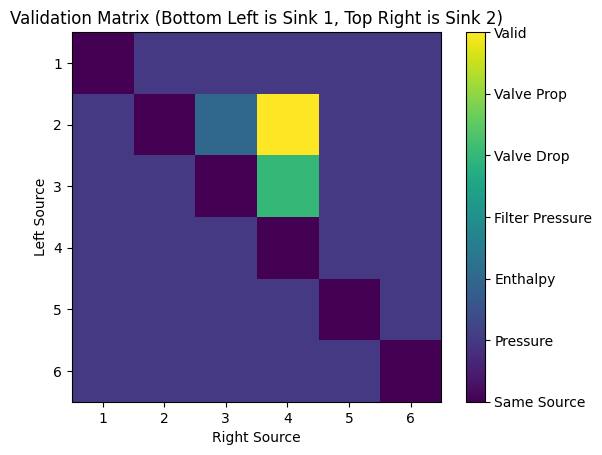

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py:510> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/ioloop.py:687] created at /usr/local/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/tasks.py:636> took 4.777 seconds


In [17]:
sink_sets = {
  1: (1, 5, 6),
  2: (2, 3, 4)
}

result_mat = np.zeros((6, 6))

failure_reasons = {"Same Source": 0,
                   "Pressure": 1,
                   "Enthalpy": 2,
                   "Filter Pressure": 3,
                   "Valve Drop": 4,
                   "Valve Prop": 5,
                   "Valid": 6}

hits = 0
tries = 0
for left in range(1, 7):
  for right in range(1, 7):
    if left != right and left < right:
      for sink in range(1, 3):
        tries += 1
        valid, reason, _ = test_setup([left, right], sink, cond_row)
        l = left - 1 if sink == 1 else right - 1
        r = right - 1 if sink == 1 else left - 1
        
        if valid:
          hits += 1
          print("left: {}, right: {}, sink: {} is valid".format(left, right, sink_sets[sink]))
          result_mat[l, r] = failure_reasons["Valid"]
        else:
          result_mat[l, r] = failure_reasons[reason]
    else:
      result_mat[left - 1, left - 1] = failure_reasons["Same Source"]


print("hits: {}, tries: {}".format(hits, tries))


plt.imshow(result_mat, cmap='viridis')
plt.xlabel('Right Source')
plt.ylabel('Left Source')
plt.title('Validation Matrix (Bottom Left is Sink 1, Top Right is Sink 2)')
plt.xticks(range(6), range(1, 7))
plt.yticks(range(6), range(1, 7))

# Add color bar with failure reasons
cbar = plt.colorbar()
cbar.set_ticks(range(len(failure_reasons)))
cbar.set_ticklabels(list(failure_reasons.keys()))

plt.show()


In [38]:
def power_draw(m_dot_two, cond_row):
  m_dot_four = m_dot_ent - m_dot_two  
  state_two = c_ohh_two.with_state(
    Input.pressure(cond_row['P2 (Pa)']), Input.temperature(cond_row['T2 (°C)'])
  )
  state_one = c_ohh_two.with_state(
    Input.pressure(cond_row['P1 (Pa)']), Input.temperature(cond_row['T1 (°C)'])
  )
  state_four = c_ohh_two.with_state(
    Input.pressure(cond_row['P2 (Pa)']), Input.temperature(cond_row['T4 (°C)'])
  )
  state_five = c_ohh_two.with_state(
    Input.pressure(cond_row['P2 (Pa)']), Input.temperature(cond_row['T5 (°C)'])
  )

  h_one = state_one.enthalpy 
  h_two = state_two.enthalpy
  h_four = state_four.enthalpy
  h_five = state_five.enthalpy

  power_loss = m_dot_two * (h_two - h_one) + m_dot_four * (h_four - h_five)
  power_gen = cond_row['m-dot (kg/s)'] * ((h_four - h_five) - (h_two - h_one))

  return power_loss, power_gen

power_draw(m_dot_ent, cond_row)


(1651.9684091202746, 23099.29240272424)

In [39]:
left = 2
right = 4
sink = 1

station = "{:05.1f}˚C"
startup = "Startup"

results = []
stations = []

it = "{0} {1} -> {2} @ {3}: [{4[2][0]:.4e}, {4[2][1]:.4e}] w/ {4[2][2]:.4e} Pa and {4[2][3]:.3f}% clogged. Taking {5:.3f}% power."

for row_ind, cond_row in operating_conditions.iterrows():
  result = test_setup([left, right], sink, cond_row)
  power_loss, total_power = power_draw(result[2][4], cond_row)


  print(it.format(left, right, sink_sets[sink], station.format(cond_row['Ambient condition (°C)']), result, power_loss / total_power * 100))

  results.append(result[2] + (power_loss / total_power * 100,))
  stations.append(cond_row['Ambient condition (°C)'])

cond_row = startup_conditions.iloc[0]
result = test_setup([left, right], sink, cond_row)
power_loss, total_power = power_draw(result[2][4], cond_row)

print(it.format(left, right, sink_sets[sink], startup, result, power_loss / total_power * 100))

results.append(result[2] + (power_loss / total_power * 100,))
stations.append(80)


2 4 -> (1, 5, 6) @ -20.0˚C: [4.3793e-02, 1.8121e-01] w/ 6.7801e+06 Pa and 97.752% clogged. Taking 3.556% power.
2 4 -> (1, 5, 6) @ -10.0˚C: [4.7237e-02, 1.7505e-01] w/ 6.8849e+06 Pa and 97.812% clogged. Taking 3.528% power.
2 4 -> (1, 5, 6) @ 000.0˚C: [4.9992e-02, 1.6536e-01] w/ 7.3925e+06 Pa and 97.982% clogged. Taking 3.295% power.
2 4 -> (1, 5, 6) @ 010.0˚C: [5.2160e-02, 1.4737e-01] w/ 8.3065e+06 Pa and 98.221% clogged. Taking 2.948% power.
2 4 -> (1, 5, 6) @ 020.0˚C: [5.6655e-02, 1.3041e-01] w/ 9.0561e+06 Pa and 98.436% clogged. Taking 2.676% power.
2 4 -> (1, 5, 6) @ 030.0˚C: [7.1842e-02, 1.2338e-01] w/ 8.4761e+06 Pa and 98.603% clogged. Taking 2.573% power.
2 4 -> (1, 5, 6) @ 040.0˚C: [1.0161e-01, 1.2669e-01] w/ 5.6535e+06 Pa and 98.569% clogged. Taking 3.030% power.
2 4 -> (1, 5, 6) @ 050.0˚C: [1.7371e-01, 9.9605e-02] w/ 2.4378e+06 Pa and 97.481% clogged. Taking 4.056% power.
2 4 -> (1, 5, 6) @ Startup: [1.2051e-01, 3.5013e-01] w/ 5.0992e+04 Pa and 83.004% clogged. Taking 11.380

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py:510> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/ioloop.py:687] created at /usr/local/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/tasks.py:636> took 23.121 seconds


In [30]:
# Define the column names
columns = ['C_V Left', 'C_V Right', 'Excess Pressure (Pa)', 'Max Clog %', 'M Dot 2', 'Power Draw %']

# Create the DataFrame
df_results = pd.DataFrame(results, columns=columns)

# Add the 'Ambient Condition' column
df_results['Ambient (˚C)'] = stations

# Make Ambient Condition the index column
df_results.set_index('Ambient (˚C)', inplace=True)


# Display the DataFrame
df_results


,C_V Left,C_V Right,Excess Pressure (Pa),Max Clog %,M Dot 2,Power Draw %
Ambient (˚C),,,,,,
-20.0,0.043793,0.181208,6.780062e+06,97.752446,0.106061,3.556264
-10.0,0.047237,0.175046,6.884901e+06,97.812225,0.111293,3.528375
0.0,0.049992,0.165363,7.392542e+06,97.981524,0.116391,3.295445
10.0,0.052160,0.147373,8.306463e+06,98.221120,0.121929,2.947942
20.0,0.056655,0.130407,9.056132e+06,98.436335,0.129911,2.675872
30.0,0.071842,0.123384,8.476083e+06,98.603381,0.145356,2.573450
40.0,0.101611,0.126693,5.653519e+06,98.569326,0.163599,3.029626
50.0,0.173714,0.099605,2.437837e+06,97.481017,0.195776,4.055767
80.0,0.120508,0.350130,5.099168e+04,83.004270,0.133144,11.380133


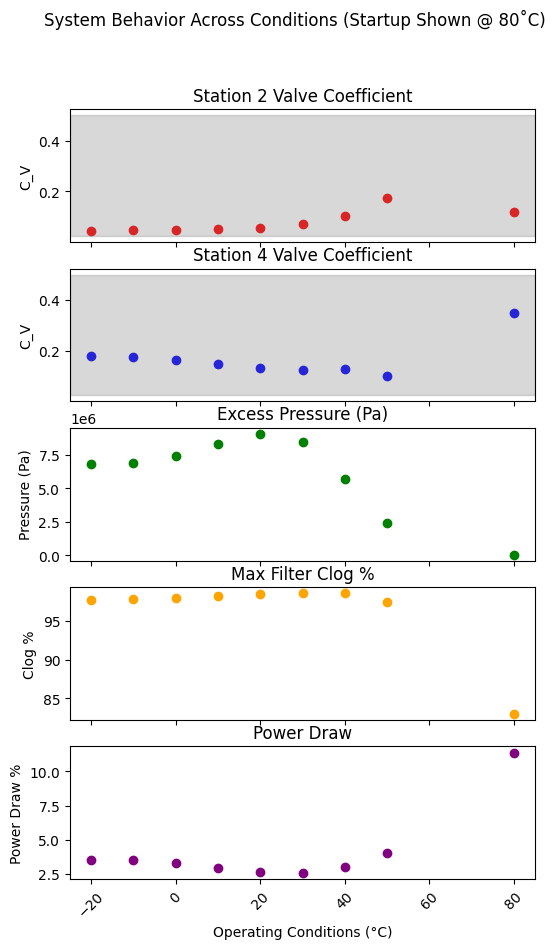

Executing <Task pending name='Task-3' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py:510> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.10/lib/python/site-packages/tornado/ioloop.py:687] created at /usr/local/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/tasks.py:636> took 0.963 seconds


In [33]:
# Extract the relevant data from the results
valve_props = [result[0] for result in results]
valve_props_two = [result[1] for result in results]
excess_pressure = [result[2] for result in results]
filter_clog_percentage = [result[3] for result in results]
power_draw = [result[5] for result in results]

# Plot the results
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(6, 10))
ax1.scatter(stations, valve_props, color='red')
ax1.set_title('Station 2 Valve Coefficient')
ax1.set_ylabel('C_V')
ax1.axhspan(0.025, 0.500, color='gray', alpha=0.3)

ax2.scatter(stations, valve_props_two, color='blue')
ax2.set_title('Station 4 Valve Coefficient')
ax2.set_ylabel('C_V')
ax2.axhspan(0.025, 0.500, color='gray', alpha=0.3)

ax3.scatter(stations, excess_pressure, color='green')
ax3.set_title('Excess Pressure (Pa)')
ax3.set_ylabel('Pressure (Pa)')

ax4.scatter(stations, filter_clog_percentage, color='orange')
ax4.set_ylabel('Clog %')
ax4.set_title('Max Filter Clog %')

ax5.scatter(stations, power_draw, color='purple')
ax5.set_xlabel('Operating Conditions (°C)')
ax5.set_ylabel('Power Draw %')
ax5.set_title('Power Draw')

plt.suptitle('System Behavior Across Conditions (Startup Shown @ 80˚C)')
plt.xticks(rotation=45)
plt.show()